# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [27]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [28]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [29]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [30]:
# Training settings
batch_size = 50
epochs = 300
lr = 1e-4
gamma = 0.9
seed = 42

In [31]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [32]:
device = 'cuda'

## Load Data

In [33]:
### read csv from Song-Mao


train_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv")
test_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_test_15395_C5.csv")


#os.makedirs('../data', exist_ok=True)

In [34]:
test_df.tail()


train_dir = '/media/joshua/Milano/galaxy_zoo/train/'
test_dir = '/media/joshua/Milano/galaxy_zoo/test/'



In [35]:
train_df["GalaxyID"][0] == int(100008)

True

In [36]:
# with zipfile.ZipFile('../data/train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('../data/test.zip') as test_zip:
#     test_zip.extractall('data')

In [37]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [38]:
 
print(f"Test Data: {len(test_list)}")

Test Data: 15395


In [39]:
labels = train_df['label']


## Random Plots

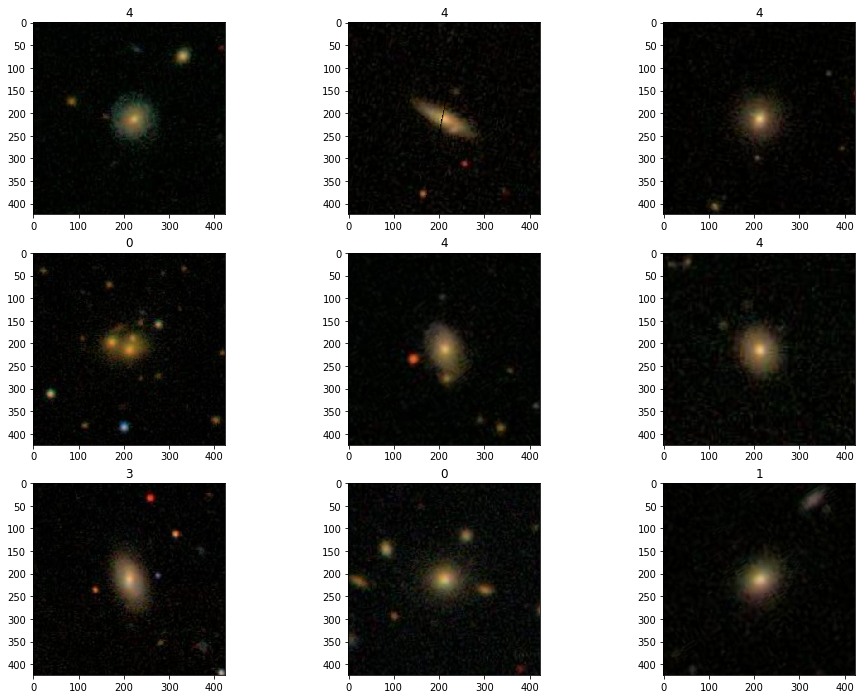

In [40]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [41]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          random_state=seed)

In [42]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 36946
Validation Data: 9237
Test Data: 15395


## Image Augumentation

In [43]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


## Load Datasets

In [44]:
class Galaxy_ZooDataset(Dataset):
    def __init__(self, file_list, transform=None, train=True, val=False, test=False):
        self.file_list = file_list
        self.transform = transform
        self.train = train
        self.val = val
        self.test = test
        self.train_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv")
        self.test_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_test_15395_C5.csv")


    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        ID = img_path.split("/")[-1].split(".")[0]
        ID = int(ID)
        #print("ID", ID)

        
        
        #print("image_path", img_path)
        if self.train or self.val:
            label = train_df[train_df['GalaxyID']==ID].label 
            #print(train_df[train_df['GalaxyID']==ID])
            
        else:
            label = test_df[test_df['GalaxyID']==ID].label 
        #print(label.values[0])
        label = int(label.values[0])

        return img_transformed, label


In [45]:
train_data = Galaxy_ZooDataset(train_list, transform=train_transforms, train=True, val=False, test=False)
valid_data = Galaxy_ZooDataset(valid_list, transform=test_transforms, train=False, val=True, test=False)
test_data = Galaxy_ZooDataset(test_list, transform=test_transforms, train=False, val=False, test=True)

In [46]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [47]:
print(len(train_data), len(train_loader))

36946 739


In [48]:
print(len(valid_data), len(valid_loader))

9237 185


## Effecient Attention

### Linformer

In [49]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [50]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=5,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [51]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [52]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            #print("label", label)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 0.9851 - acc: 0.6076 - val_loss : 0.9437 - val_acc: 0.6249




Epoch : 2 - loss : 0.9245 - acc: 0.6247 - val_loss : 0.9139 - val_acc: 0.6286




Epoch : 3 - loss : 0.9039 - acc: 0.6349 - val_loss : 0.9062 - val_acc: 0.6371




Epoch : 4 - loss : 0.8849 - acc: 0.6386 - val_loss : 0.8656 - val_acc: 0.6484




Epoch : 5 - loss : 0.8721 - acc: 0.6426 - val_loss : 0.8726 - val_acc: 0.6411




Epoch : 6 - loss : 0.8600 - acc: 0.6460 - val_loss : 0.8525 - val_acc: 0.6499




Epoch : 7 - loss : 0.8515 - acc: 0.6477 - val_loss : 0.8387 - val_acc: 0.6482




Epoch : 8 - loss : 0.8423 - acc: 0.6500 - val_loss : 0.8400 - val_acc: 0.6537




Epoch : 9 - loss : 0.8395 - acc: 0.6521 - val_loss : 0.8343 - val_acc: 0.6550




Epoch : 10 - loss : 0.8303 - acc: 0.6537 - val_loss : 0.8394 - val_acc: 0.6604




Epoch : 11 - loss : 0.8266 - acc: 0.6577 - val_loss : 0.8245 - val_acc: 0.6544




Epoch : 12 - loss : 0.8220 - acc: 0.6603 - val_loss : 0.8167 - val_acc: 0.6619




Epoch : 13 - loss : 0.8190 - acc: 0.6596 - val_loss : 0.8203 - val_acc: 0.6619




Epoch : 14 - loss : 0.8122 - acc: 0.6630 - val_loss : 0.8099 - val_acc: 0.6612




Epoch : 15 - loss : 0.8118 - acc: 0.6628 - val_loss : 0.8276 - val_acc: 0.6510




Epoch : 16 - loss : 0.8064 - acc: 0.6648 - val_loss : 0.8089 - val_acc: 0.6674




Epoch : 17 - loss : 0.8026 - acc: 0.6670 - val_loss : 0.7936 - val_acc: 0.6738




Epoch : 18 - loss : 0.8009 - acc: 0.6678 - val_loss : 0.8015 - val_acc: 0.6720




Epoch : 19 - loss : 0.7985 - acc: 0.6640 - val_loss : 0.8067 - val_acc: 0.6672




Epoch : 20 - loss : 0.7943 - acc: 0.6703 - val_loss : 0.7929 - val_acc: 0.6683




Epoch : 21 - loss : 0.7913 - acc: 0.6721 - val_loss : 0.7859 - val_acc: 0.6725




Epoch : 22 - loss : 0.7897 - acc: 0.6715 - val_loss : 0.7867 - val_acc: 0.6729




Epoch : 23 - loss : 0.7859 - acc: 0.6732 - val_loss : 0.7824 - val_acc: 0.6740




Epoch : 24 - loss : 0.7811 - acc: 0.6733 - val_loss : 0.7814 - val_acc: 0.6799




Epoch : 25 - loss : 0.7778 - acc: 0.6767 - val_loss : 0.7885 - val_acc: 0.6701




Epoch : 26 - loss : 0.7766 - acc: 0.6772 - val_loss : 0.7771 - val_acc: 0.6851




Epoch : 27 - loss : 0.7730 - acc: 0.6785 - val_loss : 0.7712 - val_acc: 0.6752




Epoch : 28 - loss : 0.7701 - acc: 0.6817 - val_loss : 0.7712 - val_acc: 0.6737




Epoch : 29 - loss : 0.7645 - acc: 0.6806 - val_loss : 0.7805 - val_acc: 0.6761




Epoch : 30 - loss : 0.7658 - acc: 0.6821 - val_loss : 0.7604 - val_acc: 0.6852




Epoch : 31 - loss : 0.7609 - acc: 0.6848 - val_loss : 0.7584 - val_acc: 0.6861




Epoch : 32 - loss : 0.7556 - acc: 0.6884 - val_loss : 0.7580 - val_acc: 0.6927




Epoch : 33 - loss : 0.7580 - acc: 0.6860 - val_loss : 0.7482 - val_acc: 0.6939




Epoch : 34 - loss : 0.7502 - acc: 0.6899 - val_loss : 0.7521 - val_acc: 0.6870




Epoch : 35 - loss : 0.7498 - acc: 0.6907 - val_loss : 0.7512 - val_acc: 0.6917




Epoch : 36 - loss : 0.7460 - acc: 0.6904 - val_loss : 0.7513 - val_acc: 0.6942




Epoch : 37 - loss : 0.7409 - acc: 0.6934 - val_loss : 0.7724 - val_acc: 0.6812




Epoch : 38 - loss : 0.7359 - acc: 0.6944 - val_loss : 0.7462 - val_acc: 0.6928




Epoch : 39 - loss : 0.7365 - acc: 0.6957 - val_loss : 0.7379 - val_acc: 0.6963




Epoch : 40 - loss : 0.7359 - acc: 0.6988 - val_loss : 0.7453 - val_acc: 0.6876




Epoch : 41 - loss : 0.7310 - acc: 0.6990 - val_loss : 0.7294 - val_acc: 0.7017




Epoch : 42 - loss : 0.7267 - acc: 0.7013 - val_loss : 0.7243 - val_acc: 0.7047




Epoch : 43 - loss : 0.7243 - acc: 0.7032 - val_loss : 0.7284 - val_acc: 0.7017




Epoch : 44 - loss : 0.7206 - acc: 0.7027 - val_loss : 0.7253 - val_acc: 0.7021




Epoch : 45 - loss : 0.7149 - acc: 0.7073 - val_loss : 0.7235 - val_acc: 0.7011




Epoch : 46 - loss : 0.7151 - acc: 0.7057 - val_loss : 0.7305 - val_acc: 0.6986




Epoch : 47 - loss : 0.7141 - acc: 0.7074 - val_loss : 0.7286 - val_acc: 0.7045




Epoch : 48 - loss : 0.7090 - acc: 0.7111 - val_loss : 0.7289 - val_acc: 0.7016




Epoch : 49 - loss : 0.7065 - acc: 0.7108 - val_loss : 0.7122 - val_acc: 0.7070




Epoch : 50 - loss : 0.7066 - acc: 0.7088 - val_loss : 0.7094 - val_acc: 0.7113




Epoch : 51 - loss : 0.7030 - acc: 0.7121 - val_loss : 0.7217 - val_acc: 0.7026




Epoch : 52 - loss : 0.7019 - acc: 0.7134 - val_loss : 0.7000 - val_acc: 0.7139




Epoch : 53 - loss : 0.6962 - acc: 0.7149 - val_loss : 0.7026 - val_acc: 0.7142




Epoch : 54 - loss : 0.6962 - acc: 0.7132 - val_loss : 0.7016 - val_acc: 0.7110




Epoch : 55 - loss : 0.6919 - acc: 0.7173 - val_loss : 0.7113 - val_acc: 0.7130




Epoch : 56 - loss : 0.6883 - acc: 0.7202 - val_loss : 0.6923 - val_acc: 0.7155




Epoch : 57 - loss : 0.6860 - acc: 0.7198 - val_loss : 0.7070 - val_acc: 0.7095




Epoch : 58 - loss : 0.6869 - acc: 0.7182 - val_loss : 0.6850 - val_acc: 0.7207




Epoch : 59 - loss : 0.6783 - acc: 0.7216 - val_loss : 0.6890 - val_acc: 0.7183




Epoch : 60 - loss : 0.6804 - acc: 0.7235 - val_loss : 0.6963 - val_acc: 0.7139




Epoch : 61 - loss : 0.6738 - acc: 0.7249 - val_loss : 0.7027 - val_acc: 0.7088




Epoch : 62 - loss : 0.6734 - acc: 0.7245 - val_loss : 0.6904 - val_acc: 0.7202




Epoch : 63 - loss : 0.6716 - acc: 0.7262 - val_loss : 0.6749 - val_acc: 0.7260




Epoch : 64 - loss : 0.6663 - acc: 0.7297 - val_loss : 0.6899 - val_acc: 0.7170




Epoch : 65 - loss : 0.6675 - acc: 0.7271 - val_loss : 0.6734 - val_acc: 0.7214




Epoch : 66 - loss : 0.6619 - acc: 0.7293 - val_loss : 0.6766 - val_acc: 0.7238




Epoch : 67 - loss : 0.6614 - acc: 0.7315 - val_loss : 0.6616 - val_acc: 0.7276




Epoch : 68 - loss : 0.6573 - acc: 0.7323 - val_loss : 0.6783 - val_acc: 0.7210




Epoch : 69 - loss : 0.6564 - acc: 0.7347 - val_loss : 0.6717 - val_acc: 0.7256




Epoch : 70 - loss : 0.6518 - acc: 0.7364 - val_loss : 0.6580 - val_acc: 0.7325




Epoch : 71 - loss : 0.6522 - acc: 0.7356 - val_loss : 0.6725 - val_acc: 0.7227




Epoch : 72 - loss : 0.6490 - acc: 0.7363 - val_loss : 0.6732 - val_acc: 0.7287




Epoch : 73 - loss : 0.6496 - acc: 0.7339 - val_loss : 0.6500 - val_acc: 0.7312




Epoch : 74 - loss : 0.6469 - acc: 0.7371 - val_loss : 0.6610 - val_acc: 0.7318




Epoch : 75 - loss : 0.6414 - acc: 0.7397 - val_loss : 0.6717 - val_acc: 0.7231




Epoch : 76 - loss : 0.6401 - acc: 0.7393 - val_loss : 0.6561 - val_acc: 0.7318




Epoch : 77 - loss : 0.6400 - acc: 0.7383 - val_loss : 0.6555 - val_acc: 0.7356




Epoch : 78 - loss : 0.6363 - acc: 0.7391 - val_loss : 0.6521 - val_acc: 0.7354




Epoch : 79 - loss : 0.6366 - acc: 0.7385 - val_loss : 0.6521 - val_acc: 0.7400




Epoch : 80 - loss : 0.6363 - acc: 0.7397 - val_loss : 0.6523 - val_acc: 0.7360




Epoch : 81 - loss : 0.6304 - acc: 0.7427 - val_loss : 0.6541 - val_acc: 0.7322




Epoch : 82 - loss : 0.6295 - acc: 0.7438 - val_loss : 0.6894 - val_acc: 0.7136




Epoch : 83 - loss : 0.6236 - acc: 0.7470 - val_loss : 0.6500 - val_acc: 0.7357




Epoch : 84 - loss : 0.6291 - acc: 0.7444 - val_loss : 0.6420 - val_acc: 0.7416




Epoch : 85 - loss : 0.6234 - acc: 0.7468 - val_loss : 0.6463 - val_acc: 0.7355




Epoch : 86 - loss : 0.6221 - acc: 0.7457 - val_loss : 0.6466 - val_acc: 0.7351




Epoch : 87 - loss : 0.6206 - acc: 0.7480 - val_loss : 0.6465 - val_acc: 0.7399




Epoch : 88 - loss : 0.6220 - acc: 0.7452 - val_loss : 0.6449 - val_acc: 0.7361




Epoch : 89 - loss : 0.6208 - acc: 0.7485 - val_loss : 0.6479 - val_acc: 0.7358




Epoch : 90 - loss : 0.6186 - acc: 0.7502 - val_loss : 0.6448 - val_acc: 0.7397




Epoch : 91 - loss : 0.6189 - acc: 0.7493 - val_loss : 0.6406 - val_acc: 0.7379




Epoch : 92 - loss : 0.6126 - acc: 0.7515 - val_loss : 0.6441 - val_acc: 0.7360




Epoch : 93 - loss : 0.6104 - acc: 0.7510 - val_loss : 0.6448 - val_acc: 0.7411




Epoch : 94 - loss : 0.6101 - acc: 0.7530 - val_loss : 0.6409 - val_acc: 0.7398




Epoch : 95 - loss : 0.6095 - acc: 0.7514 - val_loss : 0.6320 - val_acc: 0.7413




Epoch : 96 - loss : 0.6084 - acc: 0.7540 - val_loss : 0.6430 - val_acc: 0.7398




Epoch : 97 - loss : 0.6076 - acc: 0.7532 - val_loss : 0.6354 - val_acc: 0.7402




Epoch : 98 - loss : 0.6050 - acc: 0.7531 - val_loss : 0.6303 - val_acc: 0.7451




Epoch : 99 - loss : 0.6068 - acc: 0.7518 - val_loss : 0.6272 - val_acc: 0.7501




Epoch : 100 - loss : 0.6056 - acc: 0.7536 - val_loss : 0.6231 - val_acc: 0.7491




Epoch : 101 - loss : 0.6025 - acc: 0.7538 - val_loss : 0.6296 - val_acc: 0.7446




Epoch : 102 - loss : 0.5997 - acc: 0.7541 - val_loss : 0.6364 - val_acc: 0.7396




Epoch : 103 - loss : 0.6032 - acc: 0.7540 - val_loss : 0.6397 - val_acc: 0.7393




Epoch : 104 - loss : 0.6003 - acc: 0.7544 - val_loss : 0.6433 - val_acc: 0.7337




Epoch : 105 - loss : 0.5996 - acc: 0.7575 - val_loss : 0.6350 - val_acc: 0.7421




Epoch : 106 - loss : 0.5959 - acc: 0.7559 - val_loss : 0.6305 - val_acc: 0.7462




Epoch : 107 - loss : 0.5948 - acc: 0.7576 - val_loss : 0.6226 - val_acc: 0.7485




Epoch : 108 - loss : 0.5919 - acc: 0.7578 - val_loss : 0.6260 - val_acc: 0.7403




Epoch : 109 - loss : 0.5932 - acc: 0.7589 - val_loss : 0.6350 - val_acc: 0.7439




Epoch : 110 - loss : 0.5934 - acc: 0.7585 - val_loss : 0.6259 - val_acc: 0.7477




Epoch : 111 - loss : 0.5940 - acc: 0.7584 - val_loss : 0.6273 - val_acc: 0.7449




Epoch : 112 - loss : 0.5890 - acc: 0.7607 - val_loss : 0.6232 - val_acc: 0.7479




Epoch : 113 - loss : 0.5875 - acc: 0.7618 - val_loss : 0.6314 - val_acc: 0.7450




Epoch : 114 - loss : 0.5889 - acc: 0.7593 - val_loss : 0.6291 - val_acc: 0.7505




Epoch : 115 - loss : 0.5851 - acc: 0.7634 - val_loss : 0.6206 - val_acc: 0.7508




Epoch : 116 - loss : 0.5820 - acc: 0.7627 - val_loss : 0.6260 - val_acc: 0.7425




Epoch : 117 - loss : 0.5818 - acc: 0.7624 - val_loss : 0.6351 - val_acc: 0.7398




Epoch : 118 - loss : 0.5855 - acc: 0.7619 - val_loss : 0.6244 - val_acc: 0.7425




Epoch : 119 - loss : 0.5817 - acc: 0.7615 - val_loss : 0.6300 - val_acc: 0.7443




Epoch : 120 - loss : 0.5811 - acc: 0.7621 - val_loss : 0.6327 - val_acc: 0.7435




Epoch : 121 - loss : 0.5794 - acc: 0.7642 - val_loss : 0.6169 - val_acc: 0.7496




Epoch : 122 - loss : 0.5790 - acc: 0.7642 - val_loss : 0.6196 - val_acc: 0.7469




Epoch : 123 - loss : 0.5762 - acc: 0.7689 - val_loss : 0.6305 - val_acc: 0.7448




Epoch : 124 - loss : 0.5795 - acc: 0.7645 - val_loss : 0.6275 - val_acc: 0.7433




Epoch : 125 - loss : 0.5742 - acc: 0.7676 - val_loss : 0.6250 - val_acc: 0.7435




Epoch : 126 - loss : 0.5753 - acc: 0.7671 - val_loss : 0.6353 - val_acc: 0.7447




Epoch : 127 - loss : 0.5764 - acc: 0.7663 - val_loss : 0.6135 - val_acc: 0.7520




Epoch : 128 - loss : 0.5731 - acc: 0.7661 - val_loss : 0.6263 - val_acc: 0.7422




Epoch : 129 - loss : 0.5683 - acc: 0.7708 - val_loss : 0.6317 - val_acc: 0.7449




Epoch : 130 - loss : 0.5681 - acc: 0.7669 - val_loss : 0.6197 - val_acc: 0.7503




Epoch : 131 - loss : 0.5675 - acc: 0.7699 - val_loss : 0.6202 - val_acc: 0.7518




Epoch : 132 - loss : 0.5710 - acc: 0.7654 - val_loss : 0.6219 - val_acc: 0.7478




Epoch : 133 - loss : 0.5659 - acc: 0.7693 - val_loss : 0.6352 - val_acc: 0.7506




Epoch : 134 - loss : 0.5621 - acc: 0.7694 - val_loss : 0.6304 - val_acc: 0.7401




Epoch : 135 - loss : 0.5654 - acc: 0.7699 - val_loss : 0.6223 - val_acc: 0.7485




Epoch : 136 - loss : 0.5613 - acc: 0.7715 - val_loss : 0.6348 - val_acc: 0.7388




Epoch : 137 - loss : 0.5584 - acc: 0.7725 - val_loss : 0.6221 - val_acc: 0.7496




Epoch : 138 - loss : 0.5600 - acc: 0.7718 - val_loss : 0.6221 - val_acc: 0.7513




Epoch : 139 - loss : 0.5595 - acc: 0.7731 - val_loss : 0.6260 - val_acc: 0.7462




Epoch : 140 - loss : 0.5607 - acc: 0.7698 - val_loss : 0.6261 - val_acc: 0.7440




Epoch : 141 - loss : 0.5566 - acc: 0.7738 - val_loss : 0.6186 - val_acc: 0.7486




Epoch : 142 - loss : 0.5575 - acc: 0.7733 - val_loss : 0.6250 - val_acc: 0.7460




Epoch : 143 - loss : 0.5508 - acc: 0.7747 - val_loss : 0.6311 - val_acc: 0.7481




Epoch : 144 - loss : 0.5523 - acc: 0.7737 - val_loss : 0.6176 - val_acc: 0.7516




Epoch : 145 - loss : 0.5532 - acc: 0.7738 - val_loss : 0.6242 - val_acc: 0.7485




Epoch : 146 - loss : 0.5481 - acc: 0.7751 - val_loss : 0.6274 - val_acc: 0.7492




Epoch : 147 - loss : 0.5528 - acc: 0.7757 - val_loss : 0.6201 - val_acc: 0.7485




Epoch : 148 - loss : 0.5476 - acc: 0.7760 - val_loss : 0.6207 - val_acc: 0.7518




Epoch : 149 - loss : 0.5474 - acc: 0.7761 - val_loss : 0.6406 - val_acc: 0.7438




Epoch : 150 - loss : 0.5454 - acc: 0.7757 - val_loss : 0.6243 - val_acc: 0.7523




Epoch : 151 - loss : 0.5453 - acc: 0.7783 - val_loss : 0.6307 - val_acc: 0.7450




Epoch : 152 - loss : 0.5436 - acc: 0.7795 - val_loss : 0.6339 - val_acc: 0.7501




Epoch : 153 - loss : 0.5433 - acc: 0.7802 - val_loss : 0.6174 - val_acc: 0.7544




Epoch : 154 - loss : 0.5384 - acc: 0.7779 - val_loss : 0.6228 - val_acc: 0.7570




Epoch : 155 - loss : 0.5399 - acc: 0.7795 - val_loss : 0.6236 - val_acc: 0.7479




Epoch : 156 - loss : 0.5386 - acc: 0.7794 - val_loss : 0.6292 - val_acc: 0.7486




Epoch : 157 - loss : 0.5351 - acc: 0.7817 - val_loss : 0.6253 - val_acc: 0.7452




Epoch : 158 - loss : 0.5334 - acc: 0.7821 - val_loss : 0.6204 - val_acc: 0.7543




Epoch : 159 - loss : 0.5330 - acc: 0.7813 - val_loss : 0.6202 - val_acc: 0.7543




Epoch : 160 - loss : 0.5319 - acc: 0.7819 - val_loss : 0.6178 - val_acc: 0.7509




Epoch : 161 - loss : 0.5284 - acc: 0.7821 - val_loss : 0.6218 - val_acc: 0.7487




Epoch : 162 - loss : 0.5298 - acc: 0.7824 - val_loss : 0.6378 - val_acc: 0.7443




Epoch : 163 - loss : 0.5275 - acc: 0.7835 - val_loss : 0.6225 - val_acc: 0.7549




Epoch : 164 - loss : 0.5255 - acc: 0.7832 - val_loss : 0.6338 - val_acc: 0.7486




Epoch : 165 - loss : 0.5282 - acc: 0.7841 - val_loss : 0.6282 - val_acc: 0.7491




Epoch : 166 - loss : 0.5227 - acc: 0.7853 - val_loss : 0.6339 - val_acc: 0.7497




Epoch : 167 - loss : 0.5240 - acc: 0.7874 - val_loss : 0.6179 - val_acc: 0.7552




Epoch : 168 - loss : 0.5195 - acc: 0.7871 - val_loss : 0.6283 - val_acc: 0.7475




Epoch : 169 - loss : 0.5193 - acc: 0.7892 - val_loss : 0.6277 - val_acc: 0.7495




Epoch : 170 - loss : 0.5190 - acc: 0.7854 - val_loss : 0.6196 - val_acc: 0.7578




Epoch : 171 - loss : 0.5165 - acc: 0.7894 - val_loss : 0.6189 - val_acc: 0.7511




Epoch : 172 - loss : 0.5139 - acc: 0.7889 - val_loss : 0.6326 - val_acc: 0.7506




Epoch : 173 - loss : 0.5143 - acc: 0.7910 - val_loss : 0.6264 - val_acc: 0.7505




Epoch : 174 - loss : 0.5100 - acc: 0.7926 - val_loss : 0.6256 - val_acc: 0.7532




Epoch : 175 - loss : 0.5093 - acc: 0.7917 - val_loss : 0.6279 - val_acc: 0.7511




Epoch : 176 - loss : 0.5088 - acc: 0.7946 - val_loss : 0.6276 - val_acc: 0.7490




Epoch : 177 - loss : 0.5030 - acc: 0.7950 - val_loss : 0.6279 - val_acc: 0.7541




Epoch : 178 - loss : 0.5053 - acc: 0.7919 - val_loss : 0.6233 - val_acc: 0.7520




Epoch : 179 - loss : 0.5052 - acc: 0.7920 - val_loss : 0.6227 - val_acc: 0.7548




Epoch : 180 - loss : 0.5037 - acc: 0.7948 - val_loss : 0.6540 - val_acc: 0.7396




Epoch : 181 - loss : 0.4994 - acc: 0.7974 - val_loss : 0.6537 - val_acc: 0.7500




Epoch : 182 - loss : 0.5023 - acc: 0.7966 - val_loss : 0.6283 - val_acc: 0.7553




Epoch : 183 - loss : 0.4984 - acc: 0.7966 - val_loss : 0.6324 - val_acc: 0.7548




Epoch : 184 - loss : 0.4964 - acc: 0.7967 - val_loss : 0.6407 - val_acc: 0.7486




Epoch : 185 - loss : 0.4943 - acc: 0.7979 - val_loss : 0.6353 - val_acc: 0.7530




Epoch : 186 - loss : 0.4947 - acc: 0.7984 - val_loss : 0.6430 - val_acc: 0.7514




Epoch : 187 - loss : 0.4925 - acc: 0.7973 - val_loss : 0.6302 - val_acc: 0.7528




Epoch : 188 - loss : 0.4903 - acc: 0.7989 - val_loss : 0.6457 - val_acc: 0.7493




Epoch : 189 - loss : 0.4880 - acc: 0.8014 - val_loss : 0.6453 - val_acc: 0.7461




Epoch : 190 - loss : 0.4876 - acc: 0.8001 - val_loss : 0.6340 - val_acc: 0.7546




Epoch : 191 - loss : 0.4876 - acc: 0.8013 - val_loss : 0.6413 - val_acc: 0.7558




Epoch : 192 - loss : 0.4851 - acc: 0.8020 - val_loss : 0.6410 - val_acc: 0.7539




Epoch : 193 - loss : 0.4836 - acc: 0.8008 - val_loss : 0.6656 - val_acc: 0.7426




Epoch : 194 - loss : 0.4804 - acc: 0.8039 - val_loss : 0.6357 - val_acc: 0.7555




Epoch : 195 - loss : 0.4770 - acc: 0.8046 - val_loss : 0.6379 - val_acc: 0.7562




Epoch : 196 - loss : 0.4761 - acc: 0.8046 - val_loss : 0.6443 - val_acc: 0.7541




Epoch : 197 - loss : 0.4755 - acc: 0.8051 - val_loss : 0.6291 - val_acc: 0.7514




Epoch : 198 - loss : 0.4747 - acc: 0.8048 - val_loss : 0.6520 - val_acc: 0.7517




Epoch : 199 - loss : 0.4684 - acc: 0.8091 - val_loss : 0.6507 - val_acc: 0.7560




Epoch : 200 - loss : 0.4695 - acc: 0.8079 - val_loss : 0.6486 - val_acc: 0.7491




Epoch : 201 - loss : 0.4664 - acc: 0.8087 - val_loss : 0.6487 - val_acc: 0.7535




Epoch : 202 - loss : 0.4711 - acc: 0.8071 - val_loss : 0.6445 - val_acc: 0.7506




Epoch : 203 - loss : 0.4631 - acc: 0.8085 - val_loss : 0.6406 - val_acc: 0.7541




Epoch : 204 - loss : 0.4627 - acc: 0.8100 - val_loss : 0.6490 - val_acc: 0.7521




Epoch : 205 - loss : 0.4605 - acc: 0.8088 - val_loss : 0.6462 - val_acc: 0.7547




Epoch : 206 - loss : 0.4600 - acc: 0.8101 - val_loss : 0.6482 - val_acc: 0.7537




Epoch : 207 - loss : 0.4591 - acc: 0.8125 - val_loss : 0.6509 - val_acc: 0.7545




Epoch : 208 - loss : 0.4535 - acc: 0.8148 - val_loss : 0.6472 - val_acc: 0.7536




Epoch : 209 - loss : 0.4530 - acc: 0.8143 - val_loss : 0.6462 - val_acc: 0.7535




Epoch : 210 - loss : 0.4489 - acc: 0.8173 - val_loss : 0.6628 - val_acc: 0.7535




Epoch : 211 - loss : 0.4472 - acc: 0.8152 - val_loss : 0.6726 - val_acc: 0.7459




Epoch : 212 - loss : 0.4482 - acc: 0.8175 - val_loss : 0.6573 - val_acc: 0.7526




Epoch : 213 - loss : 0.4454 - acc: 0.8170 - val_loss : 0.6791 - val_acc: 0.7408




Epoch : 214 - loss : 0.4404 - acc: 0.8170 - val_loss : 0.6831 - val_acc: 0.7466




Epoch : 215 - loss : 0.4437 - acc: 0.8203 - val_loss : 0.6680 - val_acc: 0.7476




Epoch : 216 - loss : 0.4366 - acc: 0.8207 - val_loss : 0.6626 - val_acc: 0.7496




Epoch : 217 - loss : 0.4333 - acc: 0.8224 - val_loss : 0.6693 - val_acc: 0.7492




Epoch : 218 - loss : 0.4359 - acc: 0.8203 - val_loss : 0.6614 - val_acc: 0.7522




Epoch : 219 - loss : 0.4296 - acc: 0.8233 - val_loss : 0.6777 - val_acc: 0.7505




Epoch : 220 - loss : 0.4348 - acc: 0.8213 - val_loss : 0.6811 - val_acc: 0.7464




Epoch : 221 - loss : 0.4300 - acc: 0.8224 - val_loss : 0.6811 - val_acc: 0.7464




Epoch : 222 - loss : 0.4276 - acc: 0.8243 - val_loss : 0.6729 - val_acc: 0.7471




Epoch : 223 - loss : 0.4237 - acc: 0.8281 - val_loss : 0.6793 - val_acc: 0.7547




Epoch : 224 - loss : 0.4264 - acc: 0.8250 - val_loss : 0.7046 - val_acc: 0.7435




Epoch : 225 - loss : 0.4235 - acc: 0.8258 - val_loss : 0.6778 - val_acc: 0.7573




Epoch : 226 - loss : 0.4192 - acc: 0.8284 - val_loss : 0.6995 - val_acc: 0.7470




Epoch : 227 - loss : 0.4164 - acc: 0.8275 - val_loss : 0.6915 - val_acc: 0.7458




Epoch : 228 - loss : 0.4148 - acc: 0.8281 - val_loss : 0.7060 - val_acc: 0.7410




Epoch : 229 - loss : 0.4123 - acc: 0.8305 - val_loss : 0.6967 - val_acc: 0.7459




Epoch : 230 - loss : 0.4082 - acc: 0.8304 - val_loss : 0.6925 - val_acc: 0.7500




Epoch : 231 - loss : 0.4057 - acc: 0.8345 - val_loss : 0.7161 - val_acc: 0.7447




Epoch : 232 - loss : 0.4050 - acc: 0.8321 - val_loss : 0.7115 - val_acc: 0.7514




Epoch : 233 - loss : 0.4070 - acc: 0.8320 - val_loss : 0.6856 - val_acc: 0.7467




Epoch : 234 - loss : 0.4008 - acc: 0.8353 - val_loss : 0.7055 - val_acc: 0.7473




Epoch : 235 - loss : 0.3975 - acc: 0.8361 - val_loss : 0.7109 - val_acc: 0.7478




Epoch : 236 - loss : 0.3986 - acc: 0.8361 - val_loss : 0.7131 - val_acc: 0.7451




Epoch : 237 - loss : 0.3950 - acc: 0.8383 - val_loss : 0.7019 - val_acc: 0.7495




Epoch : 238 - loss : 0.3925 - acc: 0.8369 - val_loss : 0.6972 - val_acc: 0.7529




Epoch : 239 - loss : 0.3894 - acc: 0.8398 - val_loss : 0.7258 - val_acc: 0.7514




Epoch : 240 - loss : 0.3848 - acc: 0.8420 - val_loss : 0.7336 - val_acc: 0.7412




Epoch : 241 - loss : 0.3844 - acc: 0.8408 - val_loss : 0.7116 - val_acc: 0.7485




Epoch : 242 - loss : 0.3831 - acc: 0.8419 - val_loss : 0.7542 - val_acc: 0.7440




Epoch : 243 - loss : 0.3816 - acc: 0.8431 - val_loss : 0.7414 - val_acc: 0.7435




Epoch : 244 - loss : 0.3768 - acc: 0.8444 - val_loss : 0.7371 - val_acc: 0.7409




Epoch : 245 - loss : 0.3734 - acc: 0.8462 - val_loss : 0.7337 - val_acc: 0.7468




Epoch : 246 - loss : 0.3694 - acc: 0.8479 - val_loss : 0.7518 - val_acc: 0.7444




Epoch : 247 - loss : 0.3674 - acc: 0.8489 - val_loss : 0.7555 - val_acc: 0.7365




Epoch : 248 - loss : 0.3705 - acc: 0.8482 - val_loss : 0.7545 - val_acc: 0.7389




Epoch : 249 - loss : 0.3654 - acc: 0.8500 - val_loss : 0.7473 - val_acc: 0.7395




Epoch : 250 - loss : 0.3629 - acc: 0.8509 - val_loss : 0.7501 - val_acc: 0.7411




Epoch : 251 - loss : 0.3634 - acc: 0.8504 - val_loss : 0.7572 - val_acc: 0.7456




Epoch : 252 - loss : 0.3581 - acc: 0.8536 - val_loss : 0.7678 - val_acc: 0.7372




Epoch : 253 - loss : 0.3567 - acc: 0.8524 - val_loss : 0.7570 - val_acc: 0.7453




Epoch : 254 - loss : 0.3543 - acc: 0.8544 - val_loss : 0.7736 - val_acc: 0.7409




Epoch : 255 - loss : 0.3518 - acc: 0.8545 - val_loss : 0.7861 - val_acc: 0.7369




Epoch : 256 - loss : 0.3506 - acc: 0.8554 - val_loss : 0.7843 - val_acc: 0.7386




Epoch : 257 - loss : 0.3460 - acc: 0.8575 - val_loss : 0.7534 - val_acc: 0.7444




Epoch : 258 - loss : 0.3422 - acc: 0.8612 - val_loss : 0.7893 - val_acc: 0.7436




Epoch : 259 - loss : 0.3380 - acc: 0.8596 - val_loss : 0.8065 - val_acc: 0.7402




Epoch : 260 - loss : 0.3395 - acc: 0.8616 - val_loss : 0.8120 - val_acc: 0.7414




Epoch : 261 - loss : 0.3325 - acc: 0.8632 - val_loss : 0.8029 - val_acc: 0.7460




Epoch : 262 - loss : 0.3310 - acc: 0.8643 - val_loss : 0.8052 - val_acc: 0.7402




Epoch : 263 - loss : 0.3293 - acc: 0.8642 - val_loss : 0.8197 - val_acc: 0.7336




Epoch : 264 - loss : 0.3292 - acc: 0.8642 - val_loss : 0.7919 - val_acc: 0.7418




Epoch : 265 - loss : 0.3247 - acc: 0.8651 - val_loss : 0.8318 - val_acc: 0.7398




Epoch : 266 - loss : 0.3207 - acc: 0.8685 - val_loss : 0.7964 - val_acc: 0.7347




Epoch : 267 - loss : 0.3214 - acc: 0.8685 - val_loss : 0.8285 - val_acc: 0.7360




Epoch : 268 - loss : 0.3190 - acc: 0.8694 - val_loss : 0.8265 - val_acc: 0.7321




Epoch : 269 - loss : 0.3156 - acc: 0.8695 - val_loss : 0.8505 - val_acc: 0.7354




Epoch : 270 - loss : 0.3135 - acc: 0.8734 - val_loss : 0.8366 - val_acc: 0.7337




Epoch : 271 - loss : 0.3034 - acc: 0.8750 - val_loss : 0.8476 - val_acc: 0.7404




Epoch : 272 - loss : 0.3080 - acc: 0.8736 - val_loss : 0.8674 - val_acc: 0.7321




Epoch : 273 - loss : 0.3050 - acc: 0.8744 - val_loss : 0.8532 - val_acc: 0.7304




Epoch : 274 - loss : 0.3023 - acc: 0.8755 - val_loss : 0.8751 - val_acc: 0.7268




Epoch : 275 - loss : 0.3007 - acc: 0.8762 - val_loss : 0.8711 - val_acc: 0.7343




Epoch : 276 - loss : 0.2948 - acc: 0.8789 - val_loss : 0.8867 - val_acc: 0.7217




Epoch : 277 - loss : 0.2981 - acc: 0.8776 - val_loss : 0.8833 - val_acc: 0.7257




Epoch : 278 - loss : 0.2960 - acc: 0.8801 - val_loss : 0.8719 - val_acc: 0.7392




Epoch : 279 - loss : 0.2901 - acc: 0.8804 - val_loss : 0.9049 - val_acc: 0.7336




Epoch : 280 - loss : 0.2860 - acc: 0.8823 - val_loss : 0.8831 - val_acc: 0.7306




Epoch : 281 - loss : 0.2858 - acc: 0.8836 - val_loss : 0.8837 - val_acc: 0.7310




Epoch : 282 - loss : 0.2810 - acc: 0.8852 - val_loss : 0.9101 - val_acc: 0.7388




Epoch : 283 - loss : 0.2798 - acc: 0.8849 - val_loss : 0.9105 - val_acc: 0.7278




Epoch : 284 - loss : 0.2771 - acc: 0.8879 - val_loss : 0.9200 - val_acc: 0.7325




Epoch : 285 - loss : 0.2742 - acc: 0.8885 - val_loss : 0.9038 - val_acc: 0.7339




Epoch : 286 - loss : 0.2697 - acc: 0.8905 - val_loss : 0.9171 - val_acc: 0.7263




Epoch : 287 - loss : 0.2725 - acc: 0.8888 - val_loss : 0.9259 - val_acc: 0.7287




Epoch : 288 - loss : 0.2689 - acc: 0.8899 - val_loss : 0.9137 - val_acc: 0.7329




Epoch : 289 - loss : 0.2662 - acc: 0.8913 - val_loss : 0.9060 - val_acc: 0.7395




Epoch : 290 - loss : 0.2649 - acc: 0.8912 - val_loss : 0.9078 - val_acc: 0.7280




Epoch : 291 - loss : 0.2630 - acc: 0.8919 - val_loss : 0.9423 - val_acc: 0.7272




Epoch : 292 - loss : 0.2551 - acc: 0.8962 - val_loss : 0.9618 - val_acc: 0.7136




Epoch : 293 - loss : 0.2565 - acc: 0.8971 - val_loss : 0.9582 - val_acc: 0.7373




Epoch : 294 - loss : 0.2572 - acc: 0.8934 - val_loss : 0.9484 - val_acc: 0.7220




Epoch : 295 - loss : 0.2494 - acc: 0.8977 - val_loss : 0.9649 - val_acc: 0.7071




Epoch : 296 - loss : 0.2479 - acc: 0.8996 - val_loss : 0.9534 - val_acc: 0.7383




Epoch : 297 - loss : 0.2455 - acc: 0.9004 - val_loss : 0.9711 - val_acc: 0.7339




Epoch : 298 - loss : 0.2441 - acc: 0.9008 - val_loss : 0.9723 - val_acc: 0.7252




Epoch : 299 - loss : 0.2453 - acc: 0.9012 - val_loss : 0.9713 - val_acc: 0.7275




Epoch : 300 - loss : 0.2425 - acc: 0.9025 - val_loss : 1.0327 - val_acc: 0.7284



In [53]:
val_output = model(data)
val_output




tensor([[ -2.7470,  -4.7093,  -8.3413,  -5.5767,   9.3747],
        [ -9.1902,   5.6380,  -8.7389,  -7.7606,   7.3838],
        [ -6.7554,   5.3951,  -9.6082,  -6.6867,   5.5469],
        [  0.3608,  -5.7215,  -9.9545,  -2.9461,   5.3155],
        [  0.5637,   1.6770,  -7.8590,  -5.4594,   1.8115],
        [  3.3955,  -7.8962,  -8.3813,  -3.5151,   6.9534],
        [ -3.2668,   0.9461, -10.8361,  -8.8333,   8.1731],
        [ -5.1059,   9.0484,  -8.3712,  -6.6244,   1.3859],
        [ -6.7931,   2.5845,  -8.5043,   5.5813,   1.2339],
        [  3.3602,  -4.9214, -10.9784,  -2.4640,   2.8367],
        [ -6.9704,   5.2056,  -7.4002,  -0.1042,   2.0937],
        [  3.5587,  -5.6578, -10.8425,  -1.8323,   3.2177],
        [  3.4785,  -2.2717,  -9.9366, -11.1552,   6.7662],
        [ -3.1649,   2.7322, -11.5294,  -3.5012,   3.4177],
        [ -2.3007,  -2.2552, -12.5596,  -7.3937,   8.0509],
        [ -8.2992,   5.5991,  -9.3489,  -5.9501,   5.8290],
        [ -8.7627,   5.4553, -12.8989,  

In [54]:
test_data[0][1]

1

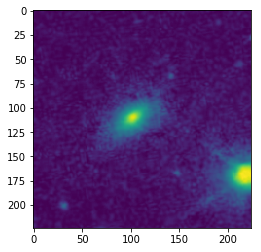

0
prediction tensor([4], device='cuda:0')


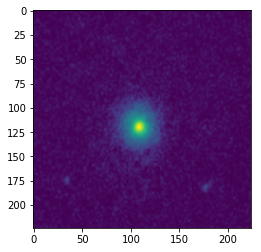

4
prediction tensor([4], device='cuda:0')


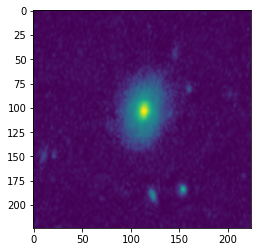

4
prediction tensor([4], device='cuda:0')


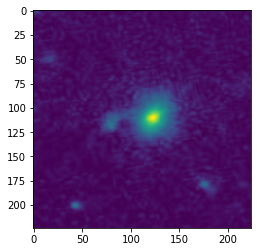

0
prediction tensor([0], device='cuda:0')


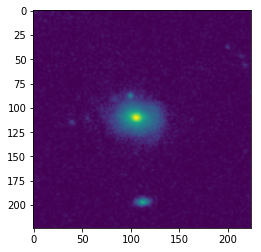

4
prediction tensor([4], device='cuda:0')


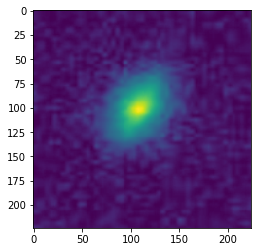

4
prediction tensor([4], device='cuda:0')


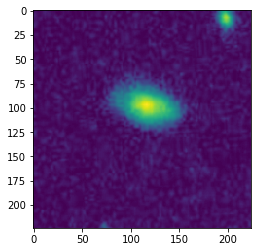

4
prediction tensor([4], device='cuda:0')


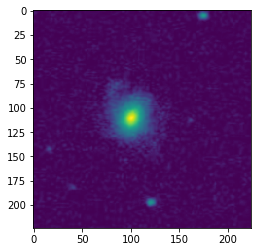

1
prediction tensor([4], device='cuda:0')


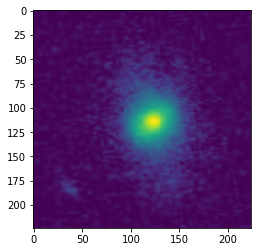

4
prediction tensor([0], device='cuda:0')


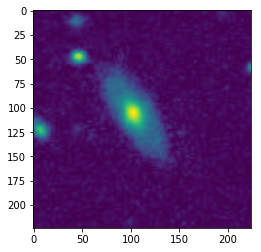

4
prediction tensor([1], device='cuda:0')


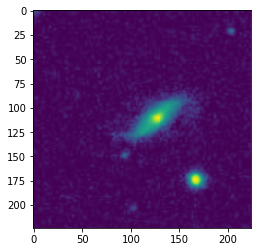

1
prediction tensor([1], device='cuda:0')


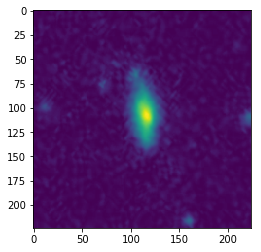

4
prediction tensor([4], device='cuda:0')


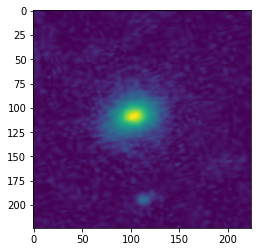

4
prediction tensor([4], device='cuda:0')


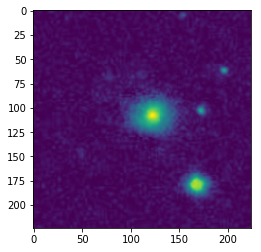

4
prediction tensor([4], device='cuda:0')


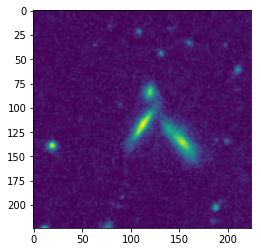

1
prediction tensor([3], device='cuda:0')


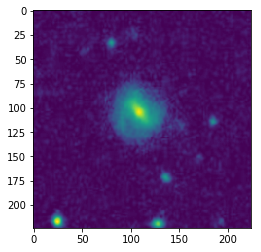

1
prediction tensor([1], device='cuda:0')


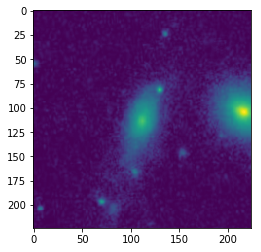

3
prediction tensor([1], device='cuda:0')


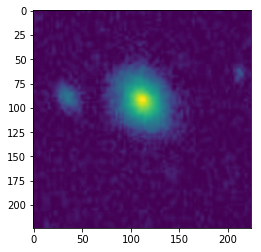

4
prediction tensor([4], device='cuda:0')


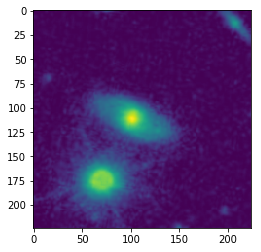

1
prediction tensor([1], device='cuda:0')


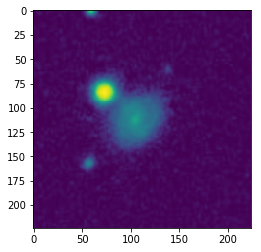

1
prediction tensor([1], device='cuda:0')


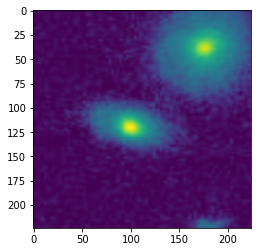

1
prediction tensor([0], device='cuda:0')


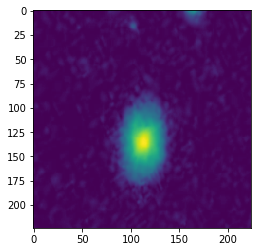

4
prediction tensor([4], device='cuda:0')


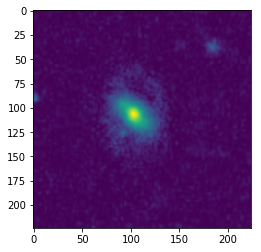

4
prediction tensor([1], device='cuda:0')


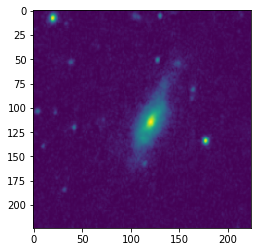

1
prediction tensor([1], device='cuda:0')


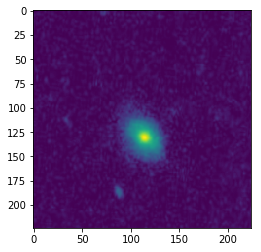

4
prediction tensor([4], device='cuda:0')


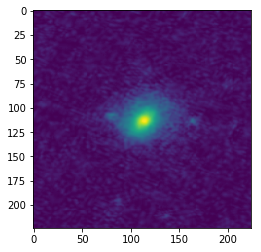

4
prediction tensor([3], device='cuda:0')


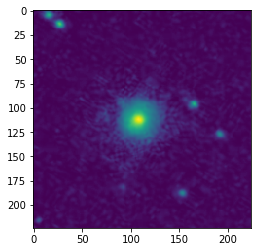

4
prediction tensor([4], device='cuda:0')


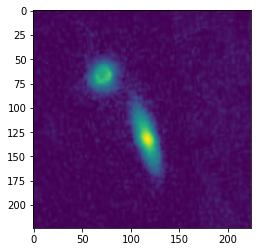

4
prediction tensor([1], device='cuda:0')


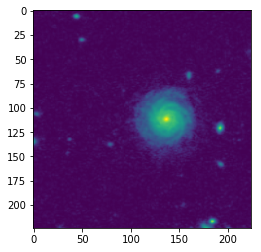

1
prediction tensor([1], device='cuda:0')


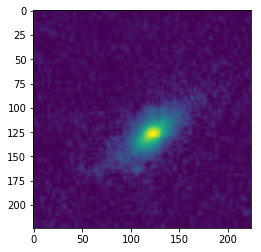

4
prediction tensor([4], device='cuda:0')


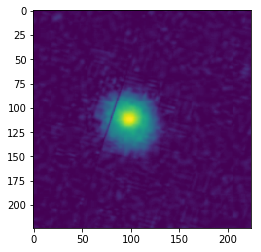

0
prediction tensor([0], device='cuda:0')


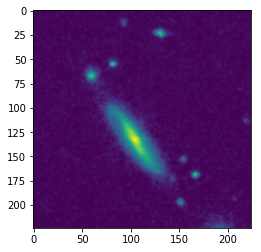

4
prediction tensor([4], device='cuda:0')


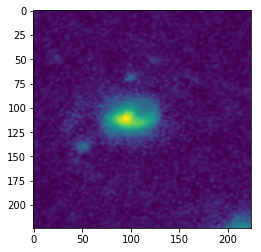

1
prediction tensor([1], device='cuda:0')


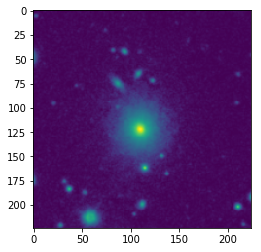

0
prediction tensor([4], device='cuda:0')


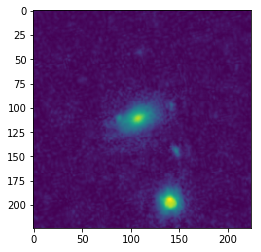

4
prediction tensor([4], device='cuda:0')


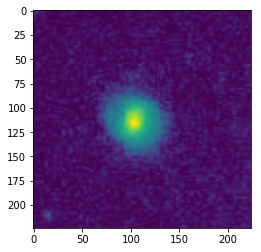

4
prediction tensor([4], device='cuda:0')


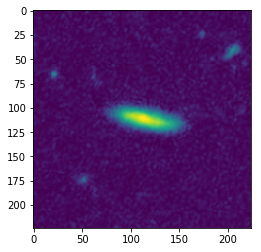

4
prediction tensor([4], device='cuda:0')


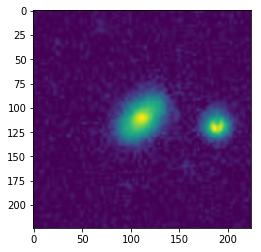

4
prediction tensor([4], device='cuda:0')


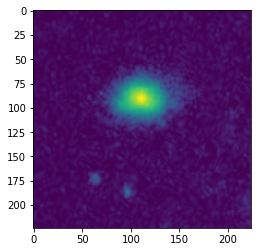

4
prediction tensor([4], device='cuda:0')


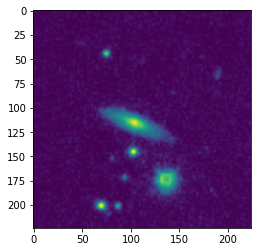

4
prediction tensor([4], device='cuda:0')


In [55]:
for idx in range(40):
    #img = Image.open(data[idx].cpu())
#     ax.set_title(labels[idx])
#     ax.imshow(test_data[idx])
    plt.imshow(valid_data[idx][0][0])
    #plt.title("label:", test_data[idx][1])
    plt.show()
    print(valid_data[idx][1])
    prediction_latent = model(valid_data[idx][0].unsqueeze(0).cuda())
    
    print("prediction", prediction_latent.argmax(dim=1))
    #print(valid_data[idx][0].shape)